### The code is a modification of the Yenni et al. (2012) analysis:
#### - runs the analysis with and without the filter S1 >= 1 & S2 >= 1
#### - includes Cushing et al. (2004) analytical results

#### their original code: https://github.com/gmyenni/RareStabilizationSimulation

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import qmc
import statsmodels.api as sm
from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(1234)

plt.rcParams.update({
    'axes.labelsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 16,
    'axes.titlesize': 18,
    'font.size': 18,
    'lines.linewidth': 1.5,
    'text.usetex': False,
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral'
})

In [3]:
def competitive_beverton_holt(N1, N2, r1, r2, a11, a22, a12, a21):
    N1_next = r1 * N1 / (1 + a11 * N1 + a12 * N2)
    N2_next = r2 * N2 / (1 + a22 * N2 + a21 * N1)
    return N1_next, N2_next

In [4]:
def check_analytical_scenarios_beverton_holt(params):
    r1, r2, a11, a22, a12, a21 = params
    if r1 <= 1 or r2 <= 1:
        return 'invalid' # Avoid division by zero
    # Calculate the analytical conditions
    cond1_left = a12
    cond1_right = a22 * (r1 - 1) / (r2 - 1)
    cond2_left = a21
    cond2_right = a11 * (r2 - 1) / (r1 - 1)
    # Check the four scenarios
    if cond1_left < cond1_right and cond2_left > cond2_right:
        return 'species1_wins'
    elif cond1_left > cond1_right and cond2_left < cond2_right:
        return 'species2_wins'
    elif cond1_left < cond1_right and cond2_left < cond2_right:
        return 'stable_coexistence'
    elif cond1_left > cond1_right and cond2_left > cond2_right:
        return 'saddle_point'
    else:
        return 'borderline' # Edge cases where inequalities are equal

In [5]:
def find_equilibrium(r1, r2, a11, a22, a12, a21, eps=1e-8):
    if r1 <= 1 or r2 <= 1:
        raise ValueError("r1 and r2 must be greater than 1")
    if a11 <= 0 or a22 <= 0:
        raise ValueError("a11 and a22 must be positive")
    D = a11 * a22 - a12 * a21
    if abs(D) < eps:
        raise ValueError("Singular matrix - no unique equilibrium")
    N1_eq = ((r1 - 1) * a22 - (r2 - 1) * a12) / D
    N2_eq = ((r2 - 1) * a11 - (r1 - 1) * a21) / D
    if N1_eq > eps and N2_eq > eps:
        return N1_eq, N2_eq, "coexistence"
    elif N1_eq > eps and N2_eq <= eps:
        N1_eq = (r1 - 1) / a11
        return N1_eq, 0, "species1_only"
    elif N2_eq > eps and N1_eq <= eps:
        N2_eq = (r2 - 1) / a22
        return 0, N2_eq, "species2_only"
    else:
        return 0, 0, "extinction"

In [6]:
def check_coexistence(r1, r2, a11, a22, a12, a21):
    if r1 <= 1 or r2 <= 1:
        return 0
    cond1 = a12 < a22 * (r1 - 1) / (r2 - 1)
    cond2 = a21 < a11 * (r2 - 1) / (r1 - 1)
    cond3 = a12 > a22 * (r1 - 1) / (r2 - 1)
    cond4 = a21 > a11 * (r2 - 1) / (r1 - 1)
    if cond1 and cond2:
        return 1
    elif cond3 and cond4:
        return 0
    else:
        return 0

In [7]:
def strength_of_stabilization(r1, r2, a11, a22, a12, a21):
    if r2 <= 1 or r1 <= 1:
        raise ValueError("r1 and r2 must be greater than 1")
    if a22 <= 0 or a11 <= 0:
        raise ValueError("a22 and a11 must be positive")
    SoS1 = r2 / (1 + (r2 - 1) * a12 / a22)
    SoS2 = r1 / (1 + (r1 - 1) * a21 / a11)
    return SoS1, SoS2

In [8]:
def compute_competitive_efficiency(r1, r2, a11, a22, a12, a21, eps=1e-6):
    CE1 = ((r1 - 1) / a12) - ((r2 - 1) / a22)
    CE2 = ((r2 - 1) / a21) - ((r1 - 1) / a11)
    return CE1, CE2

In [9]:
def calculate_nu(N1_eq, N2_eq, metric_1, metric_2):
    return 0.5 * (N1_eq - N2_eq) * (metric_1 - metric_2)

In [10]:
def identify_rare_species(N1_eq, N2_eq, rarity_threshold=0.25):
    total = N1_eq + N2_eq
    if total == 0:
        raise ValueError("Both species are extinct")
    frac1 = N1_eq / total
    frac2 = N2_eq / total
    if frac1 < rarity_threshold and frac2 >= rarity_threshold:
        return "species1_rare"
    elif frac2 < rarity_threshold and frac1 >= rarity_threshold:
        return "species2_rare"
    elif frac1 < rarity_threshold and frac2 < rarity_threshold:
        return "both_rare"
    else:
        return "neither_rare"

In [11]:
def demographic_stochasticity_simulation(r1, r2, a11, a22, a12, a21, n_simulations=200, max_time=500, seed_offset=0):
    extinction_times = []
    extinction_results = []
    for sim in range(n_simulations):
        rng = np.random.RandomState(1234 + seed_offset + sim)
        N1_eq, N2_eq, _ = find_equilibrium(r1, r2, a11, a22, a12, a21)
        N1, N2 = 5, 5
        time_steps = 0
        while N1 > 0 and N2 > 0 and time_steps < max_time:
            N1_det, N2_det = competitive_beverton_holt(N1, N2, r1, r2, a11, a22, a12, a21)
            N1 = rng.poisson(N1_det) if N1_det > 0 else 0
            N2 = rng.poisson(N2_det) if N2_det > 0 else 0
            time_steps += 1
        extinction_times.append(time_steps)
        if N1 <= 0 and N2 > 0:
            extinction_results.append("species1_extinct")
        elif N2 <= 0 and N1 > 0:
            extinction_results.append("species2_extinct")
        elif N1 <= 0 and N2 <= 0:
            extinction_results.append("both_extinct")
        else:
            extinction_results.append("coexisted")
    return extinction_results, extinction_times

def get_parameter_examples():
    return [
        {'r1': 2.0, 'r2': 2.0, 'a11': 0.5, 'a22': 0.1, 'a12': 0.05, 'a21': 0.05, 'label': 'weak_stabilization'}, # weak
        {'r1': 2.0, 'r2': 2.0, 'a11': 4.0, 'a22': 4.0, 'a12': 1.0, 'a21': 2.0, 'label': 'weak_stabilization_example'}, # weak
        {'r1': 2.0, 'r2': 1.8, 'a11': 0.4, 'a22': 0.3, 'a12': 0.08, 'a21': 0.1, 'label': 'strong_stabilization'}, # strong
        {'r1': 2.0, 'r2': 2.0, 'a11': 2.0, 'a22': 6.0, 'a12': 4.0, 'a21': 1.0, 'label': 'strong_stabilization_example'}, # strong
    ]

In [12]:
def generate_parameter_sets(n_samples=2000, eps=1e-3, seed=1234):
    sampler = qmc.LatinHypercube(d=6, seed=seed)
    samples = sampler.random(n=n_samples)
    scaled_samples = np.zeros_like(samples)
    scaled_samples[:, 0] = samples[:, 0] * (20 - (1 + eps)) + (1 + eps) # r1: (1, 20] -> (1+eps, 20] inclusive
    scaled_samples[:, 1] = samples[:, 1] * (20 - (1 + eps)) + (1 + eps) # r2: (1, 20] -> (1+eps, 20] inclusive
    scaled_samples[:, 2] = samples[:, 2] * (3 - eps) + eps # a11: (0, 3] -> (eps, 3] inclusive
    scaled_samples[:, 3] = samples[:, 3] * (3 - eps) + eps # a22: (0, 3] -> (eps, 3] inclusive
    scaled_samples[:, 4] = samples[:, 4] * (3 - eps) + eps # a12: (0, 3] -> (eps, 3] inclusive
    scaled_samples[:, 5] = samples[:, 5] * (3 - eps) + eps # a21: (0, 3] -> (eps, 3] inclusive
    return scaled_samples

In [13]:
def analyze_extinction_patterns(extinction_results, rare_species):
    if rare_species == "species1_rare":
        rare_extinct = extinction_results.count("species1_extinct")
        common_extinct = extinction_results.count("species2_extinct")
    elif rare_species == "species2_rare":
        rare_extinct = extinction_results.count("species2_extinct")
        common_extinct = extinction_results.count("species1_extinct")
    else:
        raise ValueError(f"Invalid rare_species: {rare_species}")
    total_simulations = len(extinction_results)
    coexisted = extinction_results.count("coexisted")
    rare_extinction_rate = rare_extinct / total_simulations
    common_extinction_rate = common_extinct / total_simulations
    return rare_extinction_rate, common_extinction_rate

In [14]:
def process_parameter_set(params, n_simulations_per_set=200, max_time=500, seed_offset=0):
    r1, r2, a11, a22, a12, a21 = params
    try:
        if a11 <= 0 or a22 <= 0 or (r2-1) <= 0 or (r1-1) <= 0:
            return None
        scenario = check_analytical_scenarios_beverton_holt(params)
        if scenario == 'stable_coexistence':
            N1_eq, N2_eq, eq_type = find_equilibrium(r1, r2, a11, a22, a12, a21)
            if eq_type != "coexistence":
                return None
        elif scenario == 'species1_wins':
            N1_eq = (r1 - 1) / a11
            N2_eq = 0.0
            eq_type = "species1_only"
        elif scenario == 'species2_wins':
            N1_eq = 0.0
            N2_eq = (r2 - 1) / a22
            eq_type = "species2_only"
        else:
            return None
        if eq_type != "coexistence":
            return None
        rare_status = identify_rare_species(N1_eq, N2_eq)
        if rare_status == "neither_rare" or rare_status == "both_rare":
            return None
        SoS1, SoS2 = strength_of_stabilization(r1, r2, a11, a22, a12, a21)
        nu = calculate_nu(N1_eq, N2_eq, SoS1, SoS2)
        CE1, CE2 = compute_competitive_efficiency(r1, r2, a11, a22, a12, a21)
        nu_CE = calculate_nu(N1_eq, N2_eq, CE1, CE2)
        extinction_results, extinction_times = demographic_stochasticity_simulation(
            r1, r2, a11, a22, a12, a21, n_simulations=n_simulations_per_set, max_time=max_time, seed_offset=seed_offset
        )
        mean_coexistence_time = np.mean(extinction_times)
        rare_ext_rate, common_ext_rate = analyze_extinction_patterns(
            extinction_results, rare_status
        )
        result = {
            'r1': r1, 'r2': r2, 'a11': a11, 'a22': a22, 'a12': a12, 'a21': a21,
            'N1_eq': N1_eq, 'N2_eq': N2_eq, 'SoS1': SoS1, 'SoS2': SoS2,
            'nu': nu, 'nu_CE': nu_CE, 'rare_species': rare_status,
            'self_limitation': 'strong' if nu < 0 else 'weak',
            'rare_extinction_rate': rare_ext_rate,
            'common_extinction_rate': common_ext_rate,
            'mean_coexistence_time': mean_coexistence_time
        }
        return result
    except (ValueError, ZeroDivisionError) as e:
        return None

In [15]:
def run_demographic_stochasticity_analysis(n_parameter_sets=100000, n_simulations_per_set=200, max_time=500, seed=1234):
    parameter_sets = generate_parameter_sets(n_parameter_sets, seed=seed)
    results = Parallel(n_jobs=-1, verbose=0)(
        delayed(process_parameter_set)(params, n_simulations_per_set, max_time)
        for params in parameter_sets[:]
    )
    results = [r for r in results if r is not None]
    if len(results) == 0:
        raise ValueError("No valid parameter sets found")
    return pd.DataFrame(results)

In [16]:
def bootstrap_confidence_interval(data, n_bootstrap=10000, ci=95, seed_offset=0):
    bootstrapped_means = []
    n = len(data)
    rng = np.random.RandomState(1234 + seed_offset)
    for i in range(n_bootstrap):
        sample = rng.choice(data, size=n, replace=True)
        bootstrapped_means.append(np.mean(sample))
    lower = np.percentile(bootstrapped_means, (100 - ci) / 2)
    upper = np.percentile(bootstrapped_means, 100 - (100 - ci) / 2)
    return lower, upper, bootstrapped_means

In [17]:
def bootstrap_confidence_interval_difference(data1, data2, n_bootstrap=10000, ci=95, seed_offset=0):
    bootstrapped_diffs = []
    n1, n2 = len(data1), len(data2)
    rng = np.random.RandomState(1234 + seed_offset)
    for i in range(n_bootstrap):
        sample1 = rng.choice(data1, size=n1, replace=True)
        sample2 = rng.choice(data2, size=n2, replace=True)
        bootstrapped_diffs.append(np.mean(sample1) - np.mean(sample2))
    lower = np.percentile(bootstrapped_diffs, (100 - ci) / 2)
    upper = np.percentile(bootstrapped_diffs, 100 - (100 - ci) / 2)
    return lower, upper, bootstrapped_diffs

In [18]:
def check_stochastic_dominance(weak_rates, strong_rates):
    weak_sorted = np.sort(weak_rates)
    strong_sorted = np.sort(strong_rates)
    # Calculate ECDFs at common points
    all_values = np.sort(np.unique(np.concatenate([weak_rates, strong_rates])))
    ecdf_weak = np.array([np.mean(weak_rates <= x) for x in all_values])
    ecdf_strong = np.array([np.mean(strong_rates <= x) for x in all_values])
    dominates = np.all(ecdf_weak <= ecdf_strong)
    max_difference = np.max(ecdf_strong - ecdf_weak)
    return dominates, max_difference, all_values, ecdf_weak, ecdf_strong

In [19]:
def quantile_analysis(weak_rates, strong_rates, quantiles=[0.25, 0.5, 0.75, 0.95]):
    results = {}
    for q in quantiles:
        weak_q = np.quantile(weak_rates, q)
        strong_q = np.quantile(strong_rates, q)
        difference = weak_q - strong_q
        results[f'q{int(q*100)}'] = {
            'weak': weak_q,
            'strong': strong_q,
            'difference': difference,
            'relative_ratio': weak_q / strong_q if strong_q > 0 else np.inf
        }
    return results

In [20]:
def analyze_simulation_results(results_df, metric='nu'):
    if metric == 'nu':
        condition = results_df['nu'] > 0
        strong_limitation = results_df[~condition]
        weak_limitation = results_df[condition]
        weak_label = 'Weak self-limitation (nu > 0)'
        strong_label = 'Strong self-limitation (nu < 0)'
    elif metric == 'nu_CE':
        condition = results_df['nu_CE'] > 0
        strong_limitation = results_df[~condition]
        weak_limitation = results_df[condition]
        weak_label = 'Weak fitness advantage (nu_CE > 0)'
        strong_label = 'Strong fitness advantage (nu_CE < 0)'
    else:
        raise ValueError("metric must be 'nu' or 'nu_CE'")
    if len(strong_limitation) == 0 or len(weak_limitation) == 0:
        raise ValueError("Insufficient cases for both strong and weak self-limitation")
    weak_rates = weak_limitation['mean_coexistence_time'].values
    strong_rates = strong_limitation['mean_coexistence_time'].values
    mean_diff = np.mean(weak_rates) - np.mean(strong_rates)
    relative_increase = mean_diff / np.mean(strong_rates) if np.mean(strong_rates) > 0 else np.inf
    weak_ci_lower, weak_ci_upper, _ = bootstrap_confidence_interval(weak_rates)
    strong_ci_lower, strong_ci_upper, _ = bootstrap_confidence_interval(strong_rates)
    diff_ci_lower, diff_ci_upper, boot_diffs = bootstrap_confidence_interval_difference(weak_rates, strong_rates)
    dominates, max_dom_diff, dom_values, ecdf_weak, ecdf_strong = check_stochastic_dominance(weak_rates, strong_rates)
    quantile_results = quantile_analysis(weak_rates, strong_rates)
    prop_weak_higher = np.mean([np.mean(w > strong_rates) for w in weak_rates])
    results = {
        'strong_cases': strong_limitation,
        'weak_cases': weak_limitation,
        'weak_label': weak_label,
        'strong_label': strong_label,
        'mean_analysis': {
            'weak_mean': np.mean(weak_rates),
            'strong_mean': np.mean(strong_rates),
            'mean_difference': mean_diff,
            'relative_increase': relative_increase,
            'weak_ci': (weak_ci_lower, weak_ci_upper),
            'strong_ci': (strong_ci_lower, strong_ci_upper),
            'diff_ci': (diff_ci_lower, diff_ci_upper)
        },
        'stochastic_dominance': {
            'weak_dominates_strong': dominates,
            'max_dominance_difference': max_dom_diff,
            'dominance_values': dom_values,
            'ecdf_weak': ecdf_weak,
            'ecdf_strong': ecdf_strong
        },
        'quantile_analysis': quantile_results,
        'proportion_weak_higher': prop_weak_higher,
        'bootstrap_differences': boot_diffs
    }
    return results

In [21]:
def print_analysis(results, metric='nu'):
    print("\n" + "="*50)
    if metric == 'nu':
        print("SIMULATION ANALYSIS (metric: nu - strength of self-limitation)")
    else:
        print("SIMULATION ANALYSIS (metric: nu_CE - strength of fitness advantage)")
    print("="*50)
    weak_count = len(results['weak_cases'])
    strong_count = len(results['strong_cases'])
    print(f"\nSample sizes: {results['weak_label']}: {weak_count}, {results['strong_label']}: {strong_count}")
    mean_data = results['mean_analysis']
    print(f"\n--- MEAN COMPARISON ---")
    print(f"{results['weak_label']} mean coexistence time: {mean_data['weak_mean']:.2g} (95% CI: {mean_data['weak_ci'][0]:.2g}, {mean_data['weak_ci'][1]:.2g})")
    print(f"{results['strong_label']} mean coexistence time: {mean_data['strong_mean']:.2g} (95% CI: {mean_data['strong_ci'][0]:.2g}, {mean_data['strong_ci'][1]:.2g})")
    print(f"Mean difference: {mean_data['mean_difference']:.2g} (95% CI: {mean_data['diff_ci'][0]:.2g}, {mean_data['diff_ci'][1]:.2g})")
    if np.isfinite(mean_data['relative_increase']):
        print(f"Relative increase: {mean_data['relative_increase']:.1%}")
    print(f"\n--- QUANTILE COMPARISON ---")
    quantiles = results['quantile_analysis']
    for q_name, q_data in quantiles.items():
        print(f"{q_name}%: {results['weak_label'][:5]}={q_data['weak']:.2g}, {results['strong_label'][:5]}={q_data['strong']:.2g}, Diff={q_data['difference']:.2g}")
    dom_data = results['stochastic_dominance']
    print(f"\n--- STOCHASTIC DOMINANCE ---")
    print(f"{results['weak_label']} stochastically dominates {results['strong_label']}: {dom_data['weak_dominates_strong']}")
    print(f"Maximum dominance difference: {dom_data['max_dominance_difference']:.2g}")
    print(f"\n--- PROBABILITY ANALYSIS ---")
    print(f"Probability that random {results['weak_label'][:6]} case > random {results['strong_label'][:6]} case: {results['proportion_weak_higher']:.2g}")
    print(f"\n--- ECOLOGICAL INTERPRETATION ---")
    diff_ci = results['mean_analysis']['diff_ci']
    if diff_ci[0] > 0.1:
        print("STRONG EVIDENCE: Meaningful difference in coexistence times")
        print("The effect is both statistically reliable and ecologically meaningful")
    elif diff_ci[1] > 0.1 and diff_ci[0] > 0:
        print("MODERATE EVIDENCE: Consistent difference in coexistence times")
        print("The effect direction is consistent but magnitude uncertain")
    elif diff_ci[1] > 0:
        print("WEAK EVIDENCE: Inconclusive evidence for meaningful difference")
        print("Effect may exist but is not reliably different from zero")
    else:
        print("NO EVIDENCE: No reliable difference in coexistence times")
    if results['proportion_weak_higher'] > 0.7:
        print(f"High consistency: Effect direction is consistent in {results['proportion_weak_higher']:.1%} of comparisons")
    elif results['proportion_weak_higher'] > 0.6:
        print(f"Moderate consistency: Effect direction is moderately consistent")
    else:
        print(f"Low consistency: Effect direction is inconsistent across parameter space")

In [22]:
def create_summary_tables(results_df):
    summary_table = results_df.groupby('self_limitation').agg({
        'mean_coexistence_time': ['mean', 'std', 'count'],
        'rare_extinction_rate': ['mean', 'std'],
    }).round(3)
    param_ranges = results_df.groupby('self_limitation').agg({
        'r1': ['min', 'max', 'mean'],
        'r2': ['min', 'max', 'mean'],
        'a11': ['min', 'max', 'mean'],
        'a22': ['min', 'max', 'mean'],
        'SoS1': ['min', 'max', 'mean'],
        'SoS2': ['min', 'max', 'mean'],
        'nu': ['min', 'max', 'mean']
    }).round(3)
    return summary_table, param_ranges

In [23]:
def save_results(results_df, filename="demographic_stochasticity_results.csv"):
    os.makedirs('csv', exist_ok=True)
    filepath = os.path.join('csv', filename)
    numeric_columns = ['r1', 'r2', 'a11', 'a22', 'a12', 'a21', 'N1_eq', 'N2_eq',
                      'SoS1', 'SoS2', 'nu', 'rare_extinction_rate', 'common_extinction_rate',
                      'mean_coexistence_time'
                      ]
    for col in numeric_columns:
        if col in results_df.columns:
            results_df[col] = results_df[col].apply(lambda x: float(f"{x:.2g}"))
    results_df.to_csv(filepath, index=False)
    print(f"\nDetailed results saved to: {filepath}")

In [24]:
def plot_analysis_results(results_df, analysis_results, metric='nu'):
    fig, ax = plt.subplots(figsize=(8, 6))
    strong_rates = analysis_results['strong_cases']['mean_coexistence_time'].values
    weak_rates = analysis_results['weak_cases']['mean_coexistence_time'].values
    # Filter out zeros or negative values for log scale
    strong_rates = strong_rates[strong_rates > 0]
    weak_rates = weak_rates[weak_rates > 0]
    box_data = [strong_rates, weak_rates]
    colors = ['red', 'blue']
    if metric == 'nu':
        box_labels = [r'Strong self-limitation' + '\n' + r'($\nu < 0$)', r'Weak self-limitation' + '\n' + r'($\nu \geq 0$)']
    else:
        box_labels = [r'Strong fitness advantage' + '\n' + r'($\nu_{CE} < 0$)', r'Weak fitness advantage' + '\n' + r'($\nu_{CE} \geq 0$)']
    bp = ax.boxplot(box_data, labels=box_labels, widths=0.6, patch_artist=True, showmeans=True, meanline=True, showfliers=True)
    ax.set_yscale('log')
    for i, patch in enumerate(bp['boxes']):
        patch.set_facecolor(colors[i])
        patch.set_alpha(0.6)
        patch.set_edgecolor('black')
        patch.set_linewidth(2)
    for median in bp['medians']:
        median.set_color('black')
        median.set_linewidth(2)
        median.set_linestyle('--')
    for mean in bp['means']:
        mean.set_color('yellow')
        mean.set_linewidth(2)
        mean.set_linestyle('-')
    ax.set_ylabel('Log(Mean Coexistence Time)')
    legend_elements = [
        Line2D([0], [0], color='yellow', linewidth=2, label='Mean'),
        Line2D([0], [0], color='black', linewidth=2, linestyle='--', label='Median')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    plt.tight_layout()
    os.makedirs('img', exist_ok=True)
    plt.savefig(f'img/demographic_stochasticity_analysis_{metric}_log.pdf', bbox_inches='tight', dpi=300)
    plt.show()

In [25]:
def time_simul(r1, r2, a11, a22, a12, a21, y01=5.0, y02=5.0, eps=1e-3):
    y1 = np.array([y01], dtype=np.float64)
    y2 = np.array([y02], dtype=np.float64)
    stop_run = False
    i = 0
    while not stop_run and i < 1000:
        denom1 = 1 + a11 * y1[i] + a12 * y2[i]
        denom2 = 1 + a22 * y2[i] + a21 * y1[i]
        per_cap1 = r1 / denom1
        per_cap2 = r2 / denom2
        new_y1 = y1[i] * per_cap1
        new_y2 = y2[i] * per_cap2
        y1 = np.append(y1, new_y1)
        y2 = np.append(y2, new_y2)
        if i >= 1:
            if (abs(y1[-1] - y1[-2]) < eps and abs(y2[-1] - y2[-2]) < eps):
                stop_run = True
        i += 1
    return y1, y2

In [26]:
def demographic_stochasticity_time_series(params, n_simulations=100, max_time=100, seed_offset=0):
    r1, r2, a11, a22, a12, a21 = params
    try:
        N1_eq, N2_eq, eq_type = find_equilibrium(r1, r2, a11, a22, a12, a21)
        if eq_type != "coexistence":
            return np.array([]), np.array([]), np.array([]), "not_coexistence", np.array([]), np.array([])
        rare_status = identify_rare_species(N1_eq, N2_eq)
        if rare_status not in ["species1_rare", "species2_rare"]:
            return np.array([]), np.array([]), np.array([]), "neither_rare", np.array([]), np.array([])
        time_series_rare = np.zeros((n_simulations, max_time))
        time_series_common = np.zeros((n_simulations, max_time))
        survival_mask = np.zeros(n_simulations, dtype=bool)
        extinction_times = np.full(n_simulations, max_time)
        for sim in range(n_simulations):
            rng = np.random.RandomState(1234 + seed_offset + sim)
            N1, N2 = 5, 5  # Yenni et al. (2012): start with 5 individuals of each species
            survived = True
            for t in range(max_time):
                N1_det, N2_det = competitive_beverton_holt(N1, N2, r1, r2, a11, a22, a12, a21)
                N1 = rng.poisson(N1_det) if N1_det > 0 else 0
                N2 = rng.poisson(N2_det) if N2_det > 0 else 0
                if rare_status == "species1_rare":
                    time_series_rare[sim, t] = N1
                    time_series_common[sim, t] = N2
                    if N1 <= 0 and N2 > 0:  # Rare species extinct, common survives
                        survived = False
                        extinction_times[sim] = t
                        break
                else:
                    time_series_rare[sim, t] = N2
                    time_series_common[sim, t] = N1
                    if N2 <= 0 and N1 > 0:  # Rare species extinct, common survives
                        survived = False
                        extinction_times[sim] = t
                        break
                if N1 <= 0 and N2 <= 0:  # Both extinct
                    survived = False
                    extinction_times[sim] = t
                    break
            survival_mask[sim] = survived
        time_steps = np.arange(max_time)
        return time_series_rare, time_series_common, time_steps, rare_status, survival_mask, extinction_times
    except Exception:
        return np.array([]), np.array([]), np.array([]), "error", np.array([]), np.array([])

In [27]:
def plot_examples_stochastic_time_series(metrics, examples, n_simulations=2000, max_time=200):
    figures = {}
    axes_dict = {}
    for metric in metrics:
        fig, axes = plt.subplots(2, 1, figsize=(12, 8), constrained_layout=True)
        figures[metric] = fig
        axes_dict[metric] = axes
    metric_labels = {
        'nu': r'$\nu$',
        'nu_CE': r'$\nu_{CE}$'
    }
    for row_idx, sign in enumerate(['negative', 'positive']):
        for metric in metrics:
            ax = axes_dict[metric][row_idx]
            row = examples[metric][sign]['coexistence']
            metric_label = metric_labels.get(metric, metric)
            sign_symbol = '< 0' if sign == 'negative' else '\geq 0'
            title = fr'{metric_label}$\ {sign_symbol}$'
            ax.set_title(title)
            if row is not None:
                params = [row['r1'], row['r2'], row['a11'], row['a22'], row['a12'], row['a21']]
                print(f"\n{metric_label} {sign_symbol}:")
                print(f"  r1={params[0]:.2g}, r2={params[1]:.2g}")
                print(f"  a11={params[2]:.2g}, a22={params[3]:.2g}")
                print(f"  a12={params[4]:.2g}, a21={params[5]:.2g}")
                print(f"  N1_eq={row['N1_eq']:.2g}, N2_eq={row['N2_eq']:.2g}")
                print(f"  {metric}={row[metric]:.2g}")
                seed_offset = row_idx * 1000 + 500
                time_series_rare, time_series_common, time_steps, rare_status, survival_mask, extinction_times = demographic_stochasticity_time_series(params, n_simulations, max_time, seed_offset=seed_offset)
                if len(time_series_rare) > 0 and len(time_steps) > 0 and len(survival_mask) > 0:
                    plot_stochastic_time_series(ax, time_series_rare, time_steps, survival_mask, extinction_times, max_time, metric, row_idx)
            else:
                ax.text(0.5, 0.5, 'No example found', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            if row_idx == 1:
                ax.set_xlabel('Time')
            ax.set_ylabel('Abundance')
            ax.tick_params()
    os.makedirs('img', exist_ok=True)
    for metric, fig in figures.items():
        fig.savefig(f'img/stochastic_time_series_{metric}.pdf', dpi=300)
    plt.show()
    return figures

In [28]:
def plot_stochastic_time_series(ax, time_series_rare, time_steps, survival_mask, extinction_times, max_time, metric=None, row_idx=None):
    survived = survival_mask
    extinct = ~survival_mask
    if np.any(survived):
        survived_rare = time_series_rare[survived]
        min_survived_rare = np.min(survived_rare, axis=0)
        max_survived_rare = np.max(survived_rare, axis=0)
        median_survived_rare = np.median(survived_rare, axis=0)
        ax.fill_between(time_steps, min_survived_rare, max_survived_rare, alpha=0.2, color='green', label='Surviving range')
        ax.plot(time_steps, median_survived_rare, 'g-', linewidth=2, label=f'Surviving median (n={np.sum(survived)})')
    if np.any(extinct):
        extinct_rare = time_series_rare[extinct]
        extinct_masked = np.ma.array(extinct_rare, mask=False)
        for i, ext_time in enumerate(extinction_times[extinct]):
            if ext_time < max_time:
                extinct_masked.mask[i, int(ext_time):] = True
        # Calculate min, max, median for extinct trajectories
        min_extinct_rare = np.ma.min(extinct_masked, axis=0)
        max_extinct_rare = np.ma.max(extinct_masked, axis=0)
        median_extinct_rare = np.ma.median(extinct_masked, axis=0)
        valid_mask = ~min_extinct_rare.mask & ~max_extinct_rare.mask
        if np.any(valid_mask):
            ax.fill_between(time_steps[valid_mask], min_extinct_rare[valid_mask].data, max_extinct_rare[valid_mask].data, alpha=0.2, color='red', label='Extinct range')
            ax.plot(time_steps[valid_mask], median_extinct_rare[valid_mask].data, 'r--', linewidth=2, label=f'Extinct median (n={np.sum(extinct)})')
    y_max = np.max(time_series_rare) * 1.1 if np.max(time_series_rare) > 0 else 1
    ax.set_ylim([0, y_max])
    ax.set_xlim([0, max_time - 1])
    if metric == 'nu' and row_idx == 1:
        ax.legend(loc='best')
    elif metric == 'nu_CE' and row_idx == 0:
        ax.legend(loc='best')
    median_coex_time = np.median(extinction_times)

In [29]:
def classify_sign(value):
    return 'negative' if value < 0 else 'positive'

In [30]:
def find_example_parameter_sets(metrics, results_df, n_additional_samples=50000, seed=1234):
    examples = {}
    for metric in metrics:
        examples[metric] = {
            'negative': {'coexistence': None, 'competitive_exclusion': None},  'positive': {'coexistence': None, 'competitive_exclusion': None}
        }
    print(f"\nSearching for examples in existing results for metrics: {metrics}...")
    found_counts = {metric: 0 for metric in metrics}
    total_needed = len(metrics) * 4
    for _, row in results_df.iterrows():
        if sum(found_counts.values()) >= total_needed:
            break
        if any(not np.isfinite(row[metric]) for metric in metrics):
            continue
        N1_eq, N2_eq = row['N1_eq'], row['N2_eq']
        is_coexistence = N1_eq > 0 and N2_eq > 0
        outcome = 'coexistence' if is_coexistence else 'competitive_exclusion'
        if outcome == 'coexistence':
            if N1_eq <= 1 or N2_eq <= 1:
                continue
        for metric in metrics:
            if found_counts[metric] >= 4:
                continue
            value = row[metric]
            sign = classify_sign(value)
            if examples[metric][sign][outcome] is None:
                examples[metric][sign][outcome] = row
                found_counts[metric] += 1
                print(f"  Found {metric} {sign} {outcome}:")
                print(f"    r1={row['r1']:.2g}, r2={row['r2']:.2g}")
                print(f"    a11={row['a11']:.2g}, a22={row['a22']:.2g}")
                print(f"    a12={row['a12']:.2g}, a21={row['a21']:.2g}")
                print(f"    N1_eq={N1_eq:.2g}, N2_eq={N2_eq:.2g}")
                print(f"    {metric}={value:.2g}")
    total_found = sum(found_counts.values())
    if total_found < total_needed:
        print(f"\nOnly found {total_found}/{total_needed} examples. "
              f"Generating additional parameter sets...")
        additional_params = generate_parameter_sets(n_additional_samples, seed=seed + 1000)
        for params in additional_params:
            if total_found >= total_needed:
                break
            r1, r2, a11, a22, a12, a21 = params
            if not (a11 > 0 and a22 > 0 and (r2 - 1) > 0 and (r1 - 1) > 0):
                continue
            try:
                scenario = check_analytical_scenarios_beverton_holt(params)
                if scenario == 'stable_coexistence':
                    N1_eq, N2_eq, eq_type = find_equilibrium(r1, r2, a11, a22, a12, a21)
                    if eq_type != "coexistence" or N1_eq < 1.0 or N2_eq < 1.0:
                        continue
                    is_coexistence = True
                elif scenario == 'species1_wins':
                    N1_eq = (r1 - 1) / a11
                    N2_eq = 0.0
                    is_coexistence = False
                elif scenario == 'species2_wins':
                    N1_eq = 0.0
                    N2_eq = (r2 - 1) / a22
                    is_coexistence = False
                else:
                    continue
                outcome = 'coexistence' if is_coexistence else 'competitive_exclusion'
                SoS1, SoS2 = strength_of_stabilization(r1, r2, a11, a22, a12, a21)
                CE1, CE2 = compute_competitive_efficiency(r1, r2, a11, a22, a12, a21)
                metric_values = {
                    'nu': calculate_nu(N1_eq, N2_eq, SoS1, SoS2),  'nu_CE': calculate_nu(N1_eq, N2_eq, CE1, CE2)
                }
                row_data = {
                    'r1': r1, 'r2': r2, 'a11': a11, 'a22': a22,  'a12': a12, 'a21': a21, 'N1_eq': N1_eq, 'N2_eq': N2_eq,  'nu': metric_values['nu'], 'nu_CE': metric_values['nu_CE']
                }
                for metric in metrics:
                    if found_counts[metric] >= 4:
                        continue
                    value = metric_values[metric]
                    sign = classify_sign(value)
                    if examples[metric][sign][outcome] is None:
                        examples[metric][sign][outcome] = pd.Series(row_data)
                        found_counts[metric] += 1
                        total_found += 1
                        print(f"  Generated {metric} {sign} {outcome}:")
                        print(f"    r1={r1:.2g}, r2={r2:.2g}")
                        print(f"    a11={a11:.2g}, a22={a22:.2g}")
                        print(f"    a12={a12:.2g}, a21={a21:.2g}")
                        print(f"    N1_eq={N1_eq:.2g}, N2_eq={N2_eq:.2g}")
                        print(f"    {metric}={value:.2g}")
            except Exception:
                continue
    print(f"\nFound examples:")
    for metric in metrics:
        print(f"  {metric}: {found_counts[metric]}/4 examples")
    return examples

In [31]:
def main():
    n_parameter_sets = 10000
    n_simulations_per_set = 2000
    n_additional_samples = 1000
    max_time = 500
    print("Running demographic stochasticity analysis...")
    results_df = run_demographic_stochasticity_analysis(
        n_parameter_sets=n_parameter_sets,
        n_simulations_per_set=n_simulations_per_set,
        max_time=max_time
    )
    save_results(results_df)
    metrics = ['nu', 'nu_CE']
    examples = find_example_parameter_sets(metrics, results_df, n_additional_samples)
    for metric in metrics:
        print(f"\nAnalyzing metric: {metric}")
        analysis_results = analyze_simulation_results(results_df, metric=metric)
        print_analysis(analysis_results, metric=metric)
        plot_analysis_results(results_df, analysis_results, metric=metric)
    # Plot all stochastic time series
    plot_examples_stochastic_time_series(metrics, examples, n_simulations=2000, max_time=max_time)

Running demographic stochasticity analysis...

Detailed results saved to: csv/demographic_stochasticity_results.csv

Searching for examples in existing results for metrics: ['nu', 'nu_CE']...
  Found nu negative coexistence:
    r1=15, r2=4
    a11=2.3, a22=1
    a12=0.91, a21=0.26
    N1_eq=5.7, N2_eq=1.5
    nu=-9.9
  Found nu_CE positive coexistence:
    r1=15, r2=4
    a11=2.3, a22=1
    a12=0.91, a21=0.26
    N1_eq=5.7, N2_eq=1.5
    nu_CE=16
  Found nu positive coexistence:
    r1=8.6, r2=9.8
    a11=0.92, a22=1.8
    a12=0.57, a21=0.88
    N1_eq=7.6, N2_eq=1.2
    nu=5
  Found nu_CE negative coexistence:
    r1=16, r2=9
    a11=0.51, a22=1.6
    a12=1.5, a21=0.049
    N1_eq=17, N2_eq=4.5
    nu_CE=-8e+02

Only found 4/8 examples. Generating additional parameter sets...
  Generated nu negative competitive_exclusion:
    r1=1.1, r2=3.7
    a11=0.15, a22=1.5
    a12=1.4, a21=0.73
    N1_eq=0, N2_eq=1.8
    nu=-0.26
  Generated nu_CE positive competitive_exclusion:
    r1=1.1, r2=3.

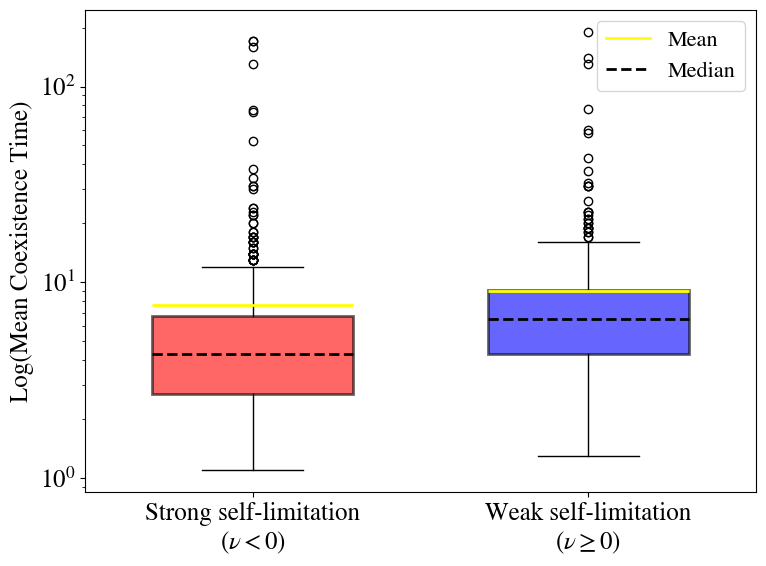


Analyzing metric: nu_CE

SIMULATION ANALYSIS (metric: nu_CE - strength of fitness advantage)

Sample sizes: Weak fitness advantage (nu_CE > 0): 632, Strong fitness advantage (nu_CE < 0): 177

--- MEAN COMPARISON ---
Weak fitness advantage (nu_CE > 0) mean coexistence time: 6.7 (95% CI: 6, 7.5)
Strong fitness advantage (nu_CE < 0) mean coexistence time: 14 (95% CI: 11, 19)
Mean difference: -7.6 (95% CI: -12, -3.8)
Relative increase: -53.2%

--- QUANTILE COMPARISON ---
q25%: Weak =3.2, Stron=3.5, Diff=-0.3
q50%: Weak =5.1, Stron=5.9, Diff=-0.8
q75%: Weak =7.8, Stron=13, Diff=-5.2
q95%: Weak =13, Stron=33, Diff=-20

--- STOCHASTIC DOMINANCE ---
Weak fitness advantage (nu_CE > 0) stochastically dominates Strong fitness advantage (nu_CE < 0): False
Maximum dominance difference: 0.0063

--- PROBABILITY ANALYSIS ---
Probability that random Weak f case > random Strong case: 0.4

--- ECOLOGICAL INTERPRETATION ---
NO EVIDENCE: No reliable difference in coexistence times
Low consistency: Effect 

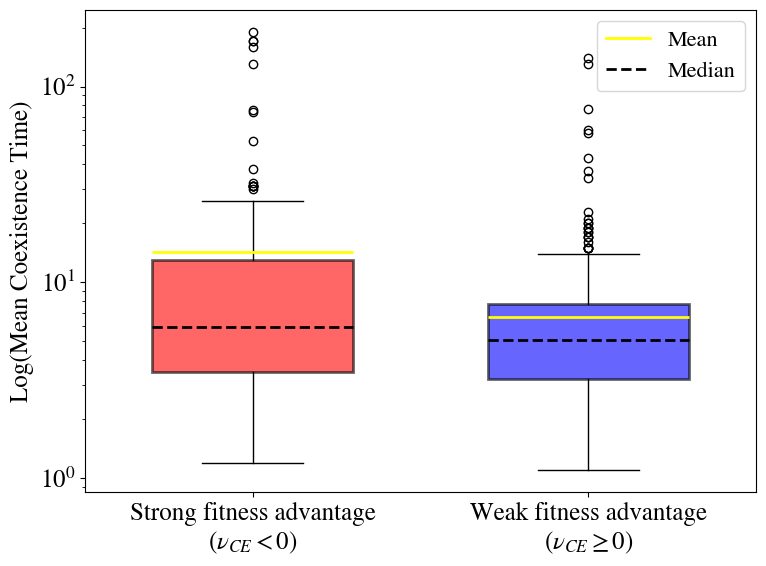


$\nu$ < 0:
  r1=15, r2=4
  a11=2.3, a22=1
  a12=0.91, a21=0.26
  N1_eq=5.7, N2_eq=1.5
  nu=-9.9

$\nu_{CE}$ < 0:
  r1=16, r2=9
  a11=0.51, a22=1.6
  a12=1.5, a21=0.049
  N1_eq=17, N2_eq=4.5
  nu_CE=-8e+02

$\nu$ \geq 0:
  r1=8.6, r2=9.8
  a11=0.92, a22=1.8
  a12=0.57, a21=0.88
  N1_eq=7.6, N2_eq=1.2
  nu=5

$\nu_{CE}$ \geq 0:
  r1=15, r2=4
  a11=2.3, a22=1
  a12=0.91, a21=0.26
  N1_eq=5.7, N2_eq=1.5
  nu_CE=16


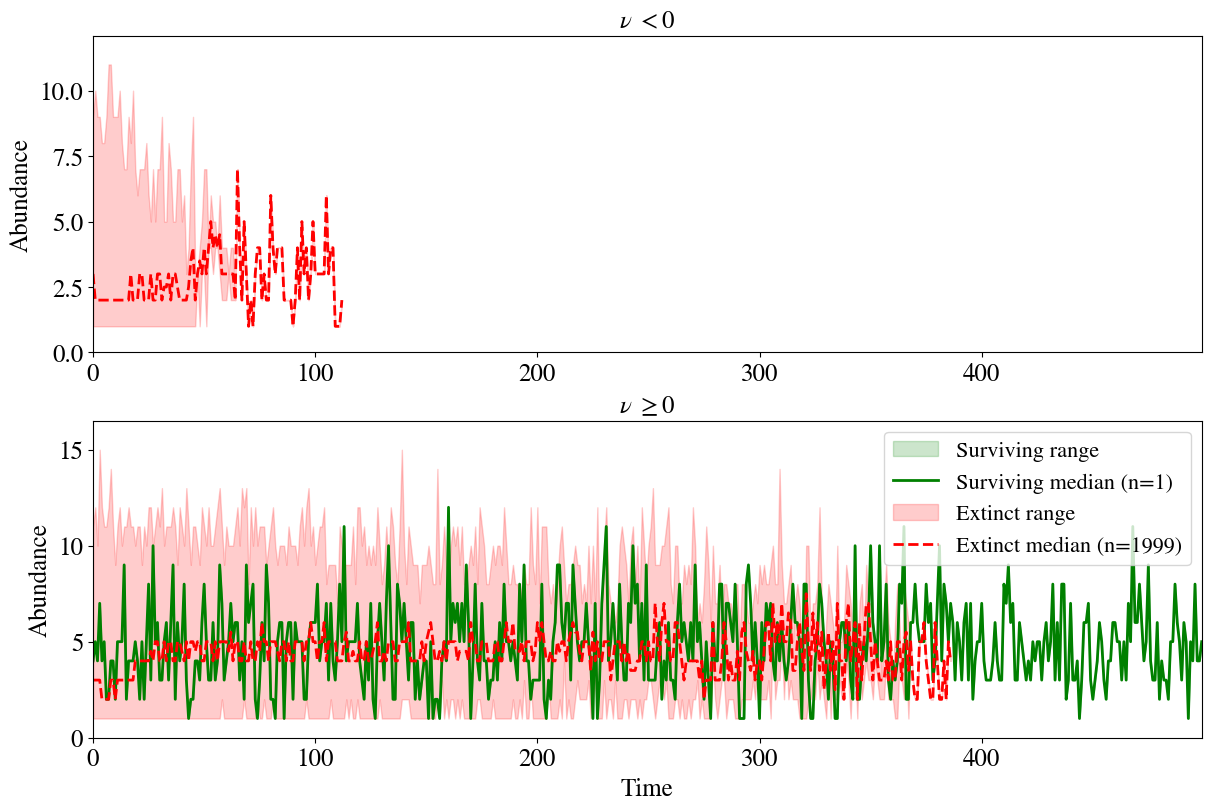

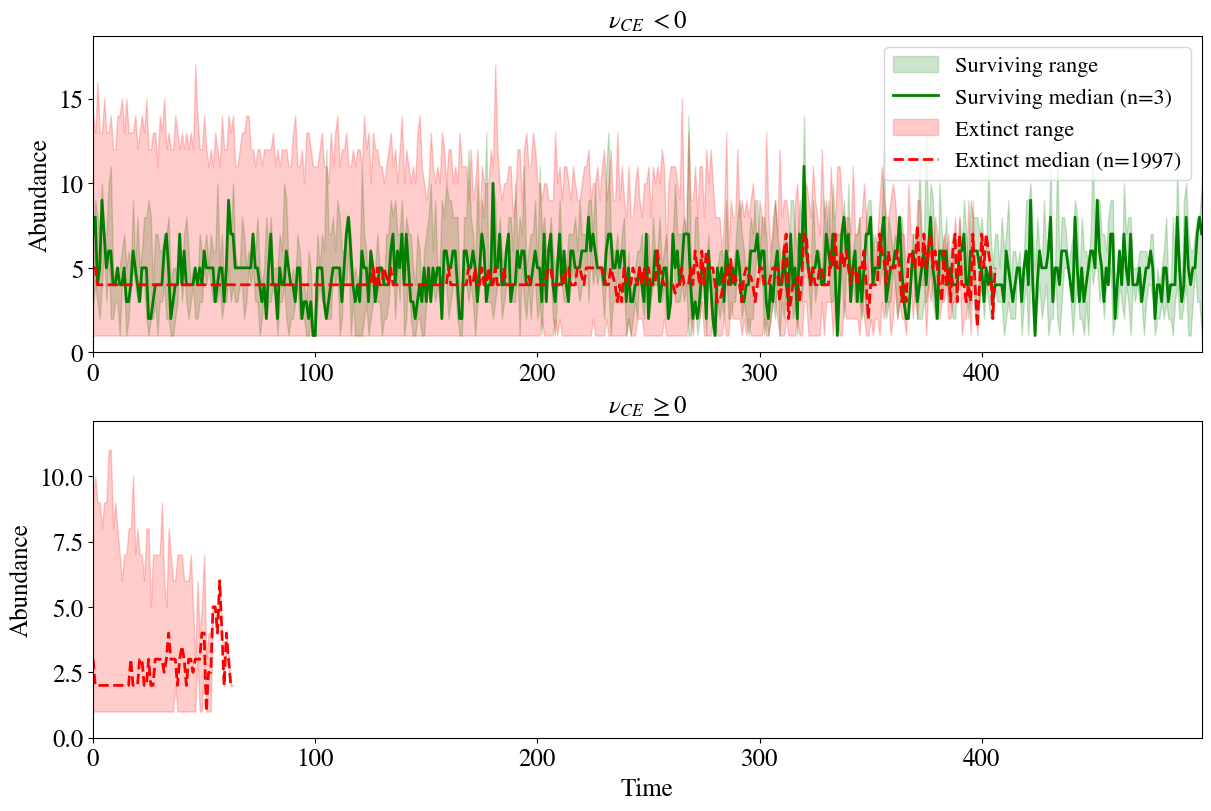

In [32]:
if __name__ == "__main__":
    main()